In [12]:
# Built-in
from pathlib import Path

# Third-party
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks_cwt
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np

# Local imports
from polya.utils import smooth

styles = ['../polya.mplstyle']


In [45]:
work = 'rip-bpa'

datadir = Path("../data/bpa")

fname = {
    "rip-bpa": "200507_RIP-cytoBPA.csv",
    "kd-bpa": '200507_KD-cytoBPA.csv',
}[work]

samples = {
    "rip-bpa": ["Input", "LARP1", "LARP4", "LARP4B"],
    "kd-bpa": ["siNC", "siLARP1", "siLARP4_4B"],
}[work]
inpfpath = datadir/fname

# Read the data
df = pd.read_csv(inpfpath, sep=',', header=5, index_col=0).dropna()
df.head(3)

,Decade1,Input,LARP1,LARP4,LARP4B,Decade2
(pixel),,,,,,
0,145362.0735,146368.8661,165762.8858,154543.2293,153199.6007,150408.9270
1,148393.7948,148800.2324,162522.7034,161981.6148,152259.1011,149454.8735
2,141866.4092,146807.8849,160101.7130,163956.0270,153281.4034,152658.9649


### Find the marker peaks

[  20  301  754 1102 1363 1564 1725 1851 1958 2048 2381 2780]


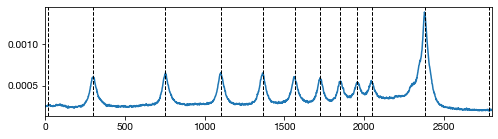

In [46]:
marker_colidx = 0

# Normalize signal intensities by lane and reverse it
df = df.div(df.sum(), axis="columns")[::-1].reset_index(drop=True)

marker_density = df.iloc[:,marker_colidx]
peaks_found = find_peaks_cwt(marker_density.dropna(), np.arange(20, 100), min_snr=1, noise_perc=5) # peak calling
print(peaks_found)

# Visualization of the peak for manual curation
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
marker_density.plot(ax=ax)
for x in peaks_found: ax.axvline(x, color='black', linestyle='dashed', linewidth=1)
# ax.set_xticks(peaks_found)
# ax.set_xticklabels(np.arange(0,len(peaks_found)))

plt.show()

### Manually add or remove the marker peaks

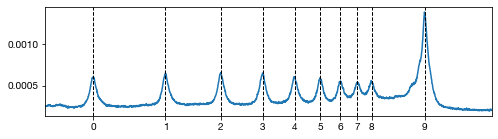

In [47]:
to_add = []
to_remove ={
    'rip-bpa':[20, 2780],
    'kd-bpa': [2453],
}[work]

marker_peaks = list(peaks_found) + to_add
marker_peaks = sorted(list(set(peaks_found) - set(to_remove)))

# Visualization of the peak for manual curation
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
marker_density.plot(ax=ax)
for x in marker_peaks: ax.axvline(x, color='black', linestyle='dashed', linewidth=1)
for x in to_add: ax.axvline(x, color="orange", ls="--", lw=1)
ax.set_xticks(marker_peaks)
ax.set_xticklabels(np.arange(0,len(marker_peaks)))

plt.show()

In [48]:
marker_labels = [20,30,40,50,60,70,80,90,100,150]

assert len(marker_labels) == len(marker_peaks)

### Draw plots

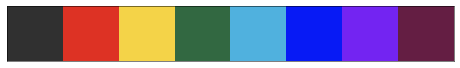

{'Input': '#303030', 'LARP1': '#DD3224', 'LARP4': '#F4D348', 'LARP4B': '#326841'}


In [49]:
with plt.style.context(styles):
    palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
    sns.palplot(palette)
    plt.show()
    
    colors = dict(zip(samples, palette))
    print( colors )

../plots/bpa_densitogram_rip-bpa_LARP1LARP4LARP4B_mini.pdf


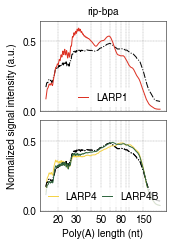

In [51]:
# Draw a figure

savefig = True
minifig = True


# samples for embedding in every figure
embedsmp = ["Input"] 
# embedsmp = ["siNC"]
subsamples = samples
nrows = 2

figsize = [4.5, 3 + 2 * nrows]

styles = ["barricade"]
if minifig is True: 
    styles.append("mini")
    figsize = list(np.array(figsize) / 2)
with plt.style.context(styles):

    fig, axes = plt.subplots(nrows, 1, figsize=figsize, sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.1)

    axi = 0
    for si, smp in enumerate(subsamples[1:]):
        ax = axes.ravel()[axi]

        for esmp in embedsmp:
            density = smooth(np.array(df.loc[:,esmp]), 50) * 1000
            ax.plot(density, ls="-.", color="black", label="")
                
        density = smooth(np.array(df.loc[:,smp]), 50) * 1000
        ax.plot(density, color=colors[smp], label=smp)
        
        ax.grid(True)
        ax.set_ylim([0,0.65])
        ax.set_yticks([0,0.5])
        ax.legend(loc="lower center", ncol=2, columnspacing=0.5, handlelength=1.0)
        
        if smp != 'LARP4': axi += 1
          
    ax.set_xticks(marker_peaks)
    marker_sizes = [20,30,50,80,150]
    ax.set_xticklabels([m if m in marker_sizes else "" for m in marker_labels])
    
    ## Shared labels
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("Poly(A) length (nt)", labelpad=18)
    ax.set_ylabel("Normalized signal intensity (a.u.)", labelpad=23)
    ax.set_title(work, fontsize="medium")

    
    fname_adduct = ""
    if minifig: fname_adduct += "_mini"
    if savefig is True:
        outfigdir = Path("../plots")
        outfigname = f"bpa_densitogram_{work}_{''.join(subsamples[1:])}" + fname_adduct + ".pdf"
        outfigpath = outfigdir/outfigname
        print( outfigpath )
        
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
    
    plt.show()
    